In [19]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from time import time
from sklearn.mixture import GaussianMixture
import sklearn
key = jax.random.PRNGKey(42)


### Load data

In [70]:
from sklearn.preprocessing import MinMaxScaler

def load_synthetic_dataset(filename):
    data = np.load(filename)
    scaler = MinMaxScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    return data

def load_cloud_dataset():
    cloud_data_name = 'cloud.data'
    with open(cloud_data_name) as f:
        cloud_data = pd.DataFrame([item.split() for item in f.readlines()])
    cloud_data = cloud_data.astype(float).to_numpy()
    scaler = MinMaxScaler()
    scaler.fit(cloud_data)
    cloud_data = scaler.transform(cloud_data)
    return cloud_data

def load_breast_cancer():
    bc_data_name = 'wdbc.data'
    with open(bc_data_name) as f:
        data_bc = pd.DataFrame([item.split(',')[2:] for item in f.readlines()])
    data_bc = data_bc.astype(float).to_numpy()
    scaler = MinMaxScaler()
    scaler.fit(data_bc)
    data_bc = scaler.transform(data_bc)
    return data_bc


### Jax GMM

In [52]:
from sklearn.cluster import kmeans_plusplus
from sklearn.cluster import KMeans

class GuassianMixtureJax:
    def __init__(self, dim, n_comp, n_init, verbose=False):
        self.dim = dim
        self.n_comp = n_comp
        self.means = None
        self.cov = None
        self.weigths = None
        self.n_init = n_init
        self.verbose = verbose
        self.is_init = False

    def fit(self, data, max_iter):
        
        if not self.is_init:
            self.km_init(data)
            
        def step_helper_fn(weights, means, cov):
            log_lik = GuassianMixtureJax.loglikelihood(data, weights, means, cov)
            new_weights_j, new_means_j, new_cov_j = GuassianMixtureJax.em_step(log_lik, data, weights, means, cov)
            
            return new_weights_j, new_means_j, new_cov_j

        step_helper_vmap = jax.vmap(step_helper_fn, (0, 0, 0), (0, 0, 0))
        
        def step_fn(state):
            i, data_, weights, means, cov = state
            new_weights_j, new_means_j, new_cov_j = step_helper_vmap(weights, means, cov)
            return i + 1, data_, new_weights_j, new_means_j, new_cov_j
        
        def cond_fn(state):
            i, data_, weights, means, cov = state
            return (i < max_iter)
        
        j, data__, new_weights, new_means, new_cov = jax.lax.while_loop(cond_fn, step_fn, (0, data, self.weights, self.means, self.cov))
     
    @staticmethod
    @jax.jit
    def em_step(log_lik, data, weigths, means, cov):
        
        eps = 1e-6
        # Expectation
        new_z = jax.nn.softmax(log_lik, 0)
        # Minimization
        # Weights
        new_weights = jnp.mean(new_z, 1)
        
        # Means
        mul = jax.vmap(lambda x, y: jnp.expand_dims(x, 1) * y, (0, None), 0)
        new_mu = jnp.sum(mul(new_z, data), 1) / jnp.expand_dims(jnp.sum(new_z, 1), 1)
        
        # Sigma
        outer_product_helper_1 = jax.vmap(lambda data, mu, z: z * jnp.expand_dims((data - mu), 1) @ jnp.expand_dims((data - mu), 1).T, (None, 0, 0), 0)
        outer_product_helper_2 = jax.vmap(outer_product_helper_1, (0, None, 0), 0)
        new_sigma = jnp.sum(outer_product_helper_2(data, new_mu, new_z.T), axis=0) / jnp.expand_dims(jnp.sum(new_z, 1), (1, 2))
        dim = new_mu.shape[1]
        n_comp = new_mu.shape[0]
        reg_eye = jnp.expand_dims(jnp.eye(dim), 0).repeat(n_comp, axis=0)
        return new_weights, new_mu, new_sigma + eps * reg_eye
            
    def k_pp_init(self, data):
        means = []
        for i in range(self.n_init):
            means.append(kmeans_plusplus(data, self.n_comp)[0])
            
        means = jnp.asarray(means)
        
        cov = jnp.expand_dims(jnp.eye(self.dim), 0)
        cov = cov.repeat(self.n_comp, 0)
        cov = jnp.expand_dims(cov, 0)
        cov = cov.repeat(self.n_init, 0)
        
        self.means = means
        self.cov = cov
        self.weights = jnp.ones([self.n_init, self.n_comp]) / self.n_comp
        
    def km_init(self, data):
        means = []
        
        for i in range(self.n_init):
            km = KMeans(n_clusters=self.n_comp, n_init=1).fit(data)
            means.append(km.cluster_centers_)
            
        cov = jnp.expand_dims(jnp.eye(self.dim), 0)
        cov = cov.repeat(self.n_comp, 0)
        cov = jnp.expand_dims(cov, 0)
        cov = cov.repeat(self.n_init, 0)
        
        global key
        key, subkey = jax.random.split(key)
        self.weights = jax.random.uniform(subkey, [self.n_init, self.n_comp])
        self.weights = self.weights / jnp.expand_dims(jnp.linalg.norm(self.weights, axis=1), 1)
        
        self.means = jnp.asarray(means)
        self.cov = cov
        self.weights = jnp.ones([self.n_init, self.n_comp]) / self.n_comp
        
    def set_params(self, weights, means, cov):
        self.weights = jnp.asarray(weights)
        self.means = jnp.asarray(means)
        self.cov = jnp.asarray(cov)
        self.is_init = True
        
    @staticmethod
    def sklearn_init(data, n_comp, n_init, init_params='kmeans'):
        new_weights, new_means, new_cov = [], [], []
        for i in range(n_init):
            gmm_sklearn = GaussianMixture(n_comp, verbose=0, verbose_interval=1, max_iter=0, n_init=n_init, init_params=init_params)
            gmm_sklearn.fit(data)

            new_weights.append(gmm_sklearn.weights_)
            new_means.append(gmm_sklearn.means_)
            new_cov.append(gmm_sklearn.covariances_)
        
        return np.array(new_weights), np.array(new_means), np.array(new_cov)
    
    @staticmethod
    @jax.jit
    def loglikelihood(data, weigths, means, cov):
        N = data.shape[0]
        res = []
        dim = means.shape[1]
        
        exp_sq = lambda data, mean, cov: -1 / 2 * (data - mean).T @ jnp.linalg.inv(cov) @ (data - mean)
        exp_sq_vmap = jax.vmap(exp_sq, (0, None, None), 0)
        
        norm_const_fn = lambda cov: - dim / 2 * jnp.log(2 * jnp.pi) - 1 / 2 * jnp.log(jnp.linalg.det(cov))
        
        norm_const_fn_vmap = jax.vmap(norm_const_fn, (0), 0)

        norm_const = norm_const_fn_vmap(cov)
        
        log_lik_fn = lambda data, means, cov, norm_const: exp_sq_vmap(data, means, cov) + norm_const
        
        log_lik_fn_vmap = jax.vmap(log_lik_fn, (None, 0, 0, 0), 0)
        
        res = log_lik_fn_vmap(data, means, cov, norm_const)
        res += jnp.log(jnp.expand_dims(weigths, 1))
        return res
        
    def score(self, data):
        ret_val = []
        for i in range(self.n_init):
            log_lik_i = self.loglikelihood(data, self.weights[i], self.means[i], self.cov[i])

            log_lik_i = jax.scipy.special.logsumexp(log_lik_i, axis=0)
            log_lik_i = log_lik_i.mean()
            ret_val.append(log_lik_i)
            
        return ret_val

In [32]:
from sklearn import datasets

data = datasets.make_blobs(n_samples=100)[0]

gmm_jax = GuassianMixtureJax(dim=data.shape[1], n_comp=3, n_init=4)

gmm_jax.fit(data, max_iter=5)
print(gmm_jax.score(data))

[Array(-3.81695795, dtype=float64), Array(-3.81695795, dtype=float64), Array(-3.81695795, dtype=float64), Array(-3.81695795, dtype=float64)]


In [33]:
from sklearn.mixture import GaussianMixture

gmm_sklearn = GaussianMixture(3, verbose=2, verbose_interval=1)

gmm_sklearn.fit(data)
print(f'Reference LogLik: {gmm_sklearn.score(data)}')

weights = gmm_sklearn.weights_
means = gmm_sklearn.means_
cov = gmm_sklearn.covariances_

gmm_jax.weights = jnp.asarray(jnp.expand_dims(weights, 0).repeat(10, 0))
gmm_jax.means = jnp.asarray(jnp.expand_dims(means, 0).repeat(10, 0))
gmm_jax.cov = jnp.asarray(jnp.expand_dims(cov, 0).repeat(10, 0))

gmm_jax.score(data)

Initialization 0
  Iteration 1	 time lapse 0.00712s	 ll change inf
  Iteration 2	 time lapse 0.00066s	 ll change 0.00000
Initialization converged: True	 time lapse 0.00780s	 ll -3.76456
Reference LogLik: -3.7645604536216717


[Array(-3.76456045, dtype=float64),
 Array(-3.76456045, dtype=float64),
 Array(-3.76456045, dtype=float64),
 Array(-3.76456045, dtype=float64)]

## Time measurements

In [64]:

def compare_sklearn_and_jax(data, n_init_list, n_comp, max_iter=5, n_runs=10):
    sklearn_time = {}
    jax_time = {}
    for n_init in n_init_list:
        # sklearn part
        time_storage = []
        for n in range(n_runs):
            gmm_sklearn = GaussianMixture(n_comp, max_iter=max_iter, n_init=n_init, init_params='kmeans')
            start = time()

            gmm_sklearn.fit(data)

            time_storage.append(time() - start)
        
        sklearn_time[n_init] = np.mean(time_storage)
        
        # jax part
        time_storage = []
        for n in range(n_runs):
            gmm_jax = GuassianMixtureJax(dim=data.shape[1], n_comp=n_comp, n_init=n_init)

            start = time()

            gmm_jax.fit(data, max_iter)

            time_storage.append(time() - start)
            
        jax_time[n_init] = np.mean(time_storage)
    return sklearn_time, jax_time
        
data = load_cloud_dataset()

sklearn_time_cloud, jax_time_cloud = compare_sklearn_and_jax(data, [5, 10, 20, 50, 100, 150], 5, n_runs=2)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceW

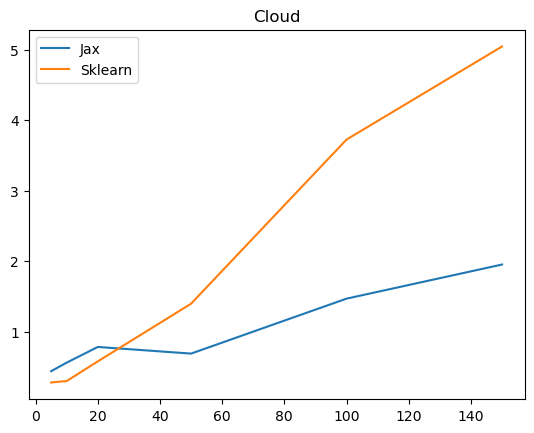

In [65]:
import matplotlib.pyplot as plt

plt.plot(jax_time_cloud.keys(), jax_time_cloud.values(), label='Jax')
plt.plot(sklearn_time_cloud.keys(), sklearn_time_cloud.values(), label='Sklearn')
plt.title('Cloud')
plt.legend()

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceW

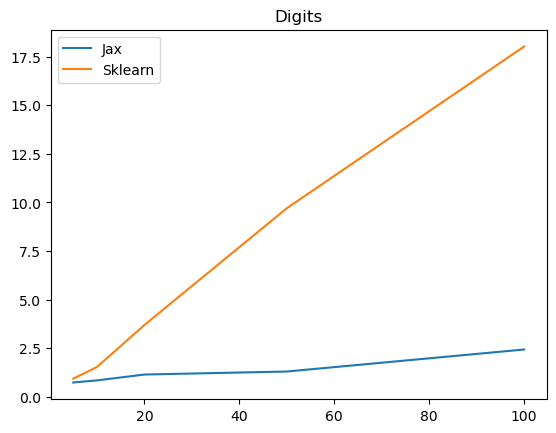

In [66]:

from sklearn.datasets import load_digits
data = load_digits()['data']

sklearn_time_digits, jax_time_digits = compare_sklearn_and_jax(data, [5, 10, 20, 50, 100], 10, n_runs=2)

plt.plot(jax_time_digits.keys(), jax_time_digits.values(), label='Jax')
plt.plot(sklearn_time_digits.keys(), sklearn_time_digits.values(), label='Sklearn')
plt.title('Digits')
plt.legend()


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceW

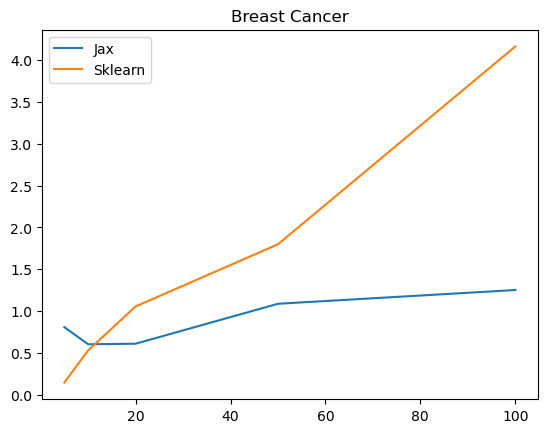

In [71]:

data = load_breast_cancer()

sklearn_time_bc, jax_time_bc = compare_sklearn_and_jax(data, [5, 10, 20, 50, 100], 10, n_runs=2)

plt.plot(jax_time_bc.keys(), jax_time_bc.values(), label='Jax')
plt.plot(sklearn_time_bc.keys(), sklearn_time_bc.values(), label='Sklearn')
plt.title('Breast Cancer')
plt.legend()